In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from src.insurance.features.engineering import prepare_data

In [6]:
df_raw = pd.read_excel("..\\src\\insurance\\data\\raw\\premiums.xlsx")
df_cleaned = prepare_data(df_raw)
df_cleaned.to_csv("..\\src\\insurance\\data\\cleaned\\premiums_cleaned.csv", index=False)

In [7]:
df_cleaned.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Medical History Score

In [86]:
df_cleaned["medical_history"].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [87]:
df_cleaned[["disease1", "disease2"]] = df_cleaned["medical_history"].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df_cleaned.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [88]:
df_cleaned = df_cleaned.fillna("none")


In [89]:
#I shall assume some risk - scores for the medical history. In this case -> worse the illness, higher the cost of insurance.

risk_scores = {
    "diabetes" : 6,
    "heart disease" : 8,
    'high blood pressure' : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

df_cleaned["total_risk_score"] = 0
for disease in ["disease1", "disease2"]:
    df_cleaned["total_risk_score"] += df_cleaned[disease].map(risk_scores)

#standarizing the total risk score
max_score = df_cleaned["total_risk_score"].max()
min_score = df_cleaned["total_risk_score"].min()
df_cleaned["normalized_risk_score"] = (df_cleaned["total_risk_score"] - min_score) / (max_score-min_score)
df_cleaned.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


### Encoding of categorical columns

In [90]:
df_cleaned["insurance_plan"].unique()
#no need for OHE - can be done with label encoding

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [91]:
df_cleaned["insurance_plan"] = df_cleaned["insurance_plan"].map({"Bronze" : 1, "Silver" : 2, "Gold" : 3})

In [92]:
df_cleaned["income_level"].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [93]:
df_cleaned["income_level"] = df_cleaned["income_level"].map({"<10L":1, "10L - 25L":2, "> 40L":4, "25L - 40L":3 })


#### One Hot Encoding

In [94]:
nominal_cols = ["gender", "region", "marital_status", "bmi_category", "smoking_status", "employment_status"]

df_encoded = pd.get_dummies(df_cleaned, columns=nominal_cols, drop_first=True, dtype=int)
df_encoded.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [95]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49953 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49953 non-null  int64  
 1   number_of_dependants             49953 non-null  int64  
 2   income_level                     49953 non-null  int64  
 3   income_lakhs                     49953 non-null  int64  
 4   medical_history                  49953 non-null  object 
 5   insurance_plan                   49953 non-null  int64  
 6   annual_premium_amount            49953 non-null  int64  
 7   disease1                         49953 non-null  object 
 8   disease2                         49953 non-null  object 
 9   total_risk_score                 49953 non-null  int64  
 10  normalized_risk_score            49953 non-null  float64
 11  gender_Male                      49953 non-null  int32  
 12  region_Northwest       

In [96]:
##  Dropping the redundand columns that were made for data preparing only
df = df_encoded.drop(["medical_history", "disease1", "disease2", "total_risk_score"], axis=1)
df.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


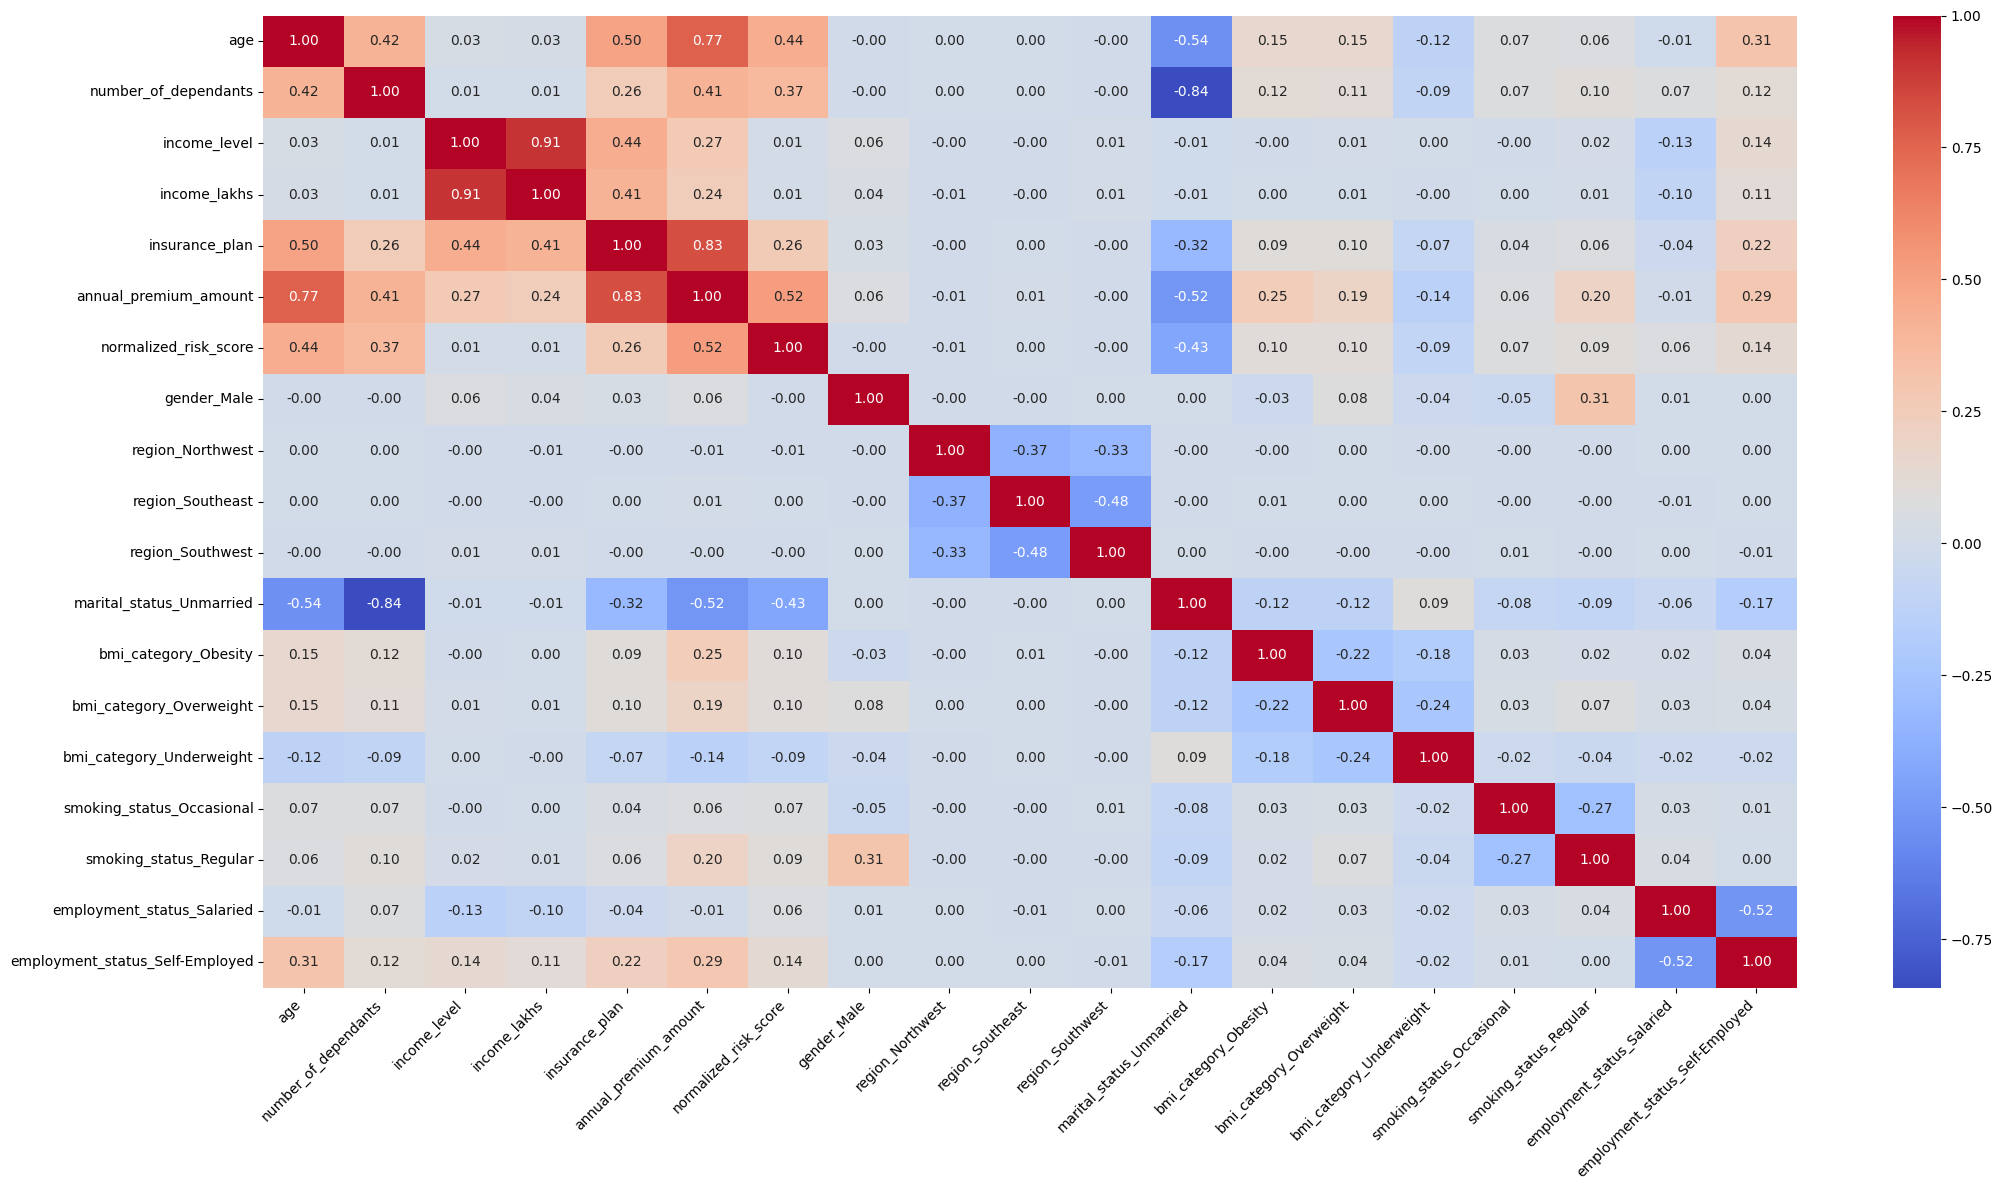

In [97]:
cm = df.corr()

plt.figure(figsize=(22,12))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Train Test Split

In [98]:
X = df.drop("annual_premium_amount", axis=1)
y = df["annual_premium_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
scaler = MinMaxScaler()
cols_to_scale = ["age", "number_of_dependants", "income_level", "income_lakhs", "insurance_plan"]
X_train_scaled = X_train.copy(deep=False)
X_test_scaled = X_test.copy(deep=False)

#scaling only those columns to ensure that there is no data-leakage
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_scaled[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

### VIF

In [100]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Column"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [ ]:
calculate_vif(X_train_scaled)
#VIF is both above 10 for income_level and income_lakhs - lets drop the higher one and check again. We want to be sure there is no bias in the training data.

,Column,VIF
0,age,4.564879
1,number_of_dependants,4.550215
2,income_level,12.424934
3,income_lakhs,11.215662
4,insurance_plan,3.572971
5,normalized_risk_score,2.687638
6,gender_Male,2.429950
7,region_Northwest,2.103506
8,region_Southeast,2.918329
9,region_Southwest,2.668086


In [104]:
calculate_vif(X_train_scaled.drop("income_level", axis=1))

,Column,VIF
0,age,4.541488
1,number_of_dependants,4.543075
2,income_lakhs,2.480604
3,insurance_plan,3.437748
4,normalized_risk_score,2.687287
5,gender_Male,2.418703
6,region_Northwest,2.101833
7,region_Southeast,2.915788
8,region_Southwest,2.665839
9,marital_status_Unmarried,3.390147


In [105]:
col_to_drop = "income_level"


X_train_scaled = X_train_scaled.drop(col_to_drop, axis=1)
X_test_scaled = X_test_scaled.drop(col_to_drop, axis=1)


In [106]:
assert list(X_train_scaled.columns) == list(X_test_scaled.columns), "Mismatch in columns between train and test"
